In [1]:
# section 1 load all the necessary modules and packages
import glob
import time
import geopandas as gpd
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# constrcute the river network topology
folder_to_save = './shp_output/'
extension = ''


In [45]:
if platform.system().lower() == "darwin": # on personal computer, shold be changed accodingly
    shp_riv = gpd.read_file('/Volumes/F:/hydrography/HDMA/processed/hdma_global_stream.shp')
elif platform.system().lower() == "linux": # on remote computer, should be changed accordigly
    shp_riv = gpd.read_file('/home/shg096/data/HDMA/processed/hdma_global_stream.shp')
shp_int = gpd.read_file(folder_to_save+'river_lake_intersect_simplified'+extension+'_final.shp')
shp_cat = None

for i in np.array([1000000,2000000,3000000,4000000,5000000,6000000]):
# for i in np.array([1000000]):
    
    shp_temp = gpd.read_file(folder_to_save+'HDMA_corrected_basin_HydroLAKES_polys_v10__final_'+\
                             str(i)+'.shp')
    shp_temp = shp_temp.drop(columns=['geometry'])
    if shp_cat is None:
        shp_cat = shp_temp 
    else:
        shp_cat = shp_cat.append(shp_temp)

In [46]:
# combine all the IDs into one time
ID_seg = np.array(shp_riv['seg_id'])
ID_lake = np.unique(np.array(shp_int['b_Hylak_id']))
ID_lake_seg = np.unique(np.array(shp_int['a_seg_id']))
ID_cat = np.array(shp_cat['ID'])
args = (ID_seg,ID_lake,ID_cat)
ID_total = np.concatenate(args)
ID_total = ID_total.squeeze()
ID_total = np.unique(ID_total)

print(ID_total)
print(len(ID_total))



[1000000 1000001 1000002 ... 8426992 8427034 8427689]
299463


In [47]:
# preparing the field to create netwrok topology:
df = pd.DataFrame()
df ['ID'] = ID_total
df ['ID_next'] = -9999
df ['length'] = 0 # 
df ['area'] = 0 # 
df ['lake'] = 0
df ['endorheic'] = 0

number_of_lakes = 0
number_of_segs = 0
number_of_hillslopes = 0
number_of_underlake = 0


warnings.simplefilter('ignore') # silent the warning

for index, row in df.iterrows():
    
    # print(index)
    
    if (row['ID'] in ID_lake) and (row['ID'] in ID_cat):

        # downstream ID
        shp_int_sub = shp_int[shp_int['b_Hylak_id'] == row['ID']] # find the slice of intersected lakes
        if shp_int_sub['outflow'].sum() == 0: # lake with no outflow
            df ['ID_next'].loc[index] = -9999
        elif shp_int_sub['outflow'].sum() == 1: # lake with outlfow
            # find the location of outflow
            shp_int_sub_temp = shp_int_sub [shp_int_sub['outflow'] == 1]
            if len(shp_int_sub_temp) > 1:
                sys.exit('there is more than one outflow for lake '+ str(row['ID']))
            df ['ID_next'].loc[index] = shp_int_sub_temp['a_seg_id'].iloc[0]
        else:
            sys.exit('there is more than one outflow for lake '+ str(row['ID']))

        # allocated area
        shp_cat_sub = shp_cat[shp_cat['ID']==row['ID']]
        if len(shp_cat_sub) > 1: 
            sys.exit('there is more than 1 elmenet with the same ID in cat_lake: '+ str(row['ID']))
        df['area'].loc[index] = shp_cat_sub['area_cor'].iloc[0]

        # lake flag
        df ['lake'].loc[index] = 1

        # endorheic lake
        if df ['ID_next'].loc[index] == -9999:
            df ['endorheic'].loc[index] = 1

        number_of_lakes = number_of_lakes + 1

    if (not (row['ID'] in ID_lake)) and (row['ID'] in ID_cat): # not a lake but exist in the cat

        # allocated area
        shp_cat_sub = shp_cat[shp_cat['ID']==row['ID']]
        if len(shp_cat_sub) > 1: 
            sys.exit('there is more than 1 elmenet with the same ID in cat_lake: '+ str(row['ID']))
        df['area'].loc[index] = shp_cat_sub['area_cor'].iloc[0]
        

        if (row['ID'] in ID_seg): # it exists in the segment

            if (row['ID'] in ID_lake_seg): # the ID is under lake and should be corrected
                shp_int_sub = shp_int[shp_int['a_seg_id'] == row['ID']]

                if len(shp_int_sub) > 1:
                    sys.exit('there is more than 1 elmenet with the same ID in cat_lake: '+ str(row['ID']))
                
                df ['length'].loc[index] = shp_int_sub ['corr_Len'].iloc[0]
                
                if shp_int_sub ['inflow'].iloc[0] == 1:
                    df ['ID_next'].loc[index] = shp_int_sub ['b_Hylak_id'].iloc[0]
                    
                elif shp_int_sub ['outflow'].iloc[0] == 1:
                    df ['ID_next'].loc[index] = shp_int_sub ['a_Tosegmen'].iloc[0]
                    # ensure the upstream of outflow are directly going to the lake
                    shp_riv_sub = shp_riv[shp_riv['Tosegment'] == row['ID']]
                    if not shp_riv_sub.empty:
                        up_IDs = np.array(shp_riv_sub['seg_id'])
                        temp = df [df['ID'].isin(up_IDs)]
                        indx = temp.index
                        df['ID_next'].loc[indx] = shp_int_sub ['b_Hylak_id'].iloc[0]
                else:
                    sys.exit('neither inflow or outflow to the lake: '+ str(row['ID']))
                    

            else:
                # allocate the doanstream
                shp_riv_sub = shp_riv[shp_riv['seg_id'] == row['ID']] # find the slice of intersected lakes

                if len(shp_riv_sub) >1:
                    sys.exit('there is more than 1 elmenet with the same ID in cat_lake: '+ str(row['ID']))

                df ['ID_next'].loc[index] = shp_riv_sub ['Tosegment'].iloc[0]
                df ['length'].loc[index] = shp_riv_sub ['Length'].iloc[0]

            #
            number_of_segs = number_of_segs + 1

        if not (row['ID'] in ID_seg): # it doesnt exists in the segment so it is hillslope

            #
            number_of_hillslopes = number_of_hillslopes + 1
            
    if (row['ID'] in ID_seg) and not (row['ID'] in ID_cat): # in segment but not in the corrected cat, meanign under lake
        print(row['ID']) 

        # downstream ID
        shp_int_sub = shp_int[shp_int['a_seg_id'] == row['ID']] # find the slice of intersected lakes
        if shp_int_sub['outflow'].sum() == 0: # lake with no outflow
            print(index)
            print(len(df))
            df ['ID_next'].loc[index] = shp_int_sub['b_Hylak_id'].iloc[0]
        else:
            sys.exit('there is more than one outflow for lake '+ str(row['ID']))
            
        number_of_underlake = number_of_underlake + 1


warnings.simplefilter('default') # silent the warning


df.to_csv('../data/Network_topology.csv')



1007521
7521
299463
1026800
26800
299463
1027508
27508
299463
1028673
28673
299463
1029266
29266
299463
1029345
29345
299463
1029533
29533
299463
1029963
29963
299463
1031340
31340
299463
1031976
31976
299463
1032138
32138
299463
1032513
32513
299463
1033417
33417
299463
1033734
33734
299463
1034240
34240
299463
1034874
34874
299463
1035052
35052
299463
1035360
35360
299463
1035448
35448
299463
1035903
35903
299463
1037153
37153
299463
1037392
37392
299463
1038198
38198
299463
1038648
38648
299463
1038809
38809
299463
1039076
39076
299463
1039677
39677
299463
1040033
40033
299463
1040072
40072
299463
1040867
40867
299463
1041071
41071
299463
1041491
41491
299463
1041806
41806
299463
1041941
41941
299463
1041967
41967
299463
1042671
42671
299463
1042783
42783
299463
1043400
43400
299463
1043461
43461
299463
1043815
43815
299463
1043819
43819
299463
1044701
44701
299463
1045044
45044
299463
1045229
45229
299463
1045305
45305
299463
1045616
45616
299463
1045677
45677
299463
1045808
45808


2057043
133373
299463
2057049
133379
299463
2057097
133427
299463
2057112
133442
299463
2057129
133459
299463
2057185
133515
299463
2057341
133671
299463
2057347
133677
299463
2057442
133772
299463
2057738
134068
299463
2057836
134166
299463
2057838
134168
299463
2057917
134247
299463
2057929
134259
299463
2058028
134358
299463
2058192
134522
299463
2058222
134552
299463
2058412
134742
299463
2058456
134786
299463
2058547
134877
299463
2058658
134988
299463
2058744
135074
299463
2058772
135102
299463
2058953
135283
299463
2058986
135316
299463
2059049
135379
299463
2059191
135521
299463
2059295
135625
299463
2059327
135657
299463
2059447
135777
299463
2059448
135778
299463
2059475
135805
299463
2059537
135867
299463
2059714
136044
299463
2059772
136102
299463
2059814
136144
299463
2059853
136183
299463
2059865
136195
299463
2059961
136291
299463
2060031
136361
299463
2060051
136381
299463
2060069
136399
299463
2060085
136415
299463
2060101
136431
299463
2060102
136432
299463
2060131
13

3043088
185755
299463
3043099
185766
299463
3043100
185767
299463
3043117
185784
299463
3043139
185806
299463
3043141
185808
299463
3043146
185813
299463
3043170
185837
299463
3043182
185849
299463
3043213
185880
299463
3043254
185921
299463
3043292
185959
299463
3043301
185968
299463
3043332
185999
299463
3043365
186032
299463
3043427
186094
299463
3043439
186106
299463
3043494
186161
299463
3043522
186189
299463
3043553
186220
299463
3043570
186237
299463
3043578
186245
299463
3043590
186257
299463
3043603
186270
299463
3043612
186279
299463
3043636
186303
299463
3043667
186334
299463
3043680
186347
299463
3043685
186352
299463
3043691
186358
299463
3043701
186368
299463
3043710
186377
299463
3043721
186388
299463
3043736
186403
299463
3043752
186419
299463
3043761
186428
299463
3043774
186441
299463
3043835
186502
299463
3043848
186515
299463
3043857
186524
299463
3043867
186534
299463
3043880
186547
299463
3043885
186552
299463
3043899
186566
299463
3043903
186570
299463
3043917
18

5035673
267865
299463
5035747
267939
299463
5036343
268535
299463
5036456
268648
299463
5036651
268843
299463
6011638
282244
299463
6012620
283226
299463
6012859
283465
299463
6013208
283814
299463
6013250
283856
299463
6013964
284570
299463
6014037
284643
299463
6015116
285722
299463
6015466
286072
299463
6015642
286248
299463
6015687
286293
299463
6015710
286316
299463
6016235
286841
299463
6016248
286854
299463
6016613
287219
299463
6016946
287552
299463
6017093
287699
299463
6017578
288184
299463
6018068
288674
299463
6018122
288728
299463
6018174
288780
299463
6018200
288806
299463
6018459
289065
299463
6018633
289239
299463
6018863
289469
299463
6018894
289500
299463
6018947
289553
299463
6019012
289618
299463
6019126
289732
299463
6019387
289993
299463
6019504
290110
299463
6019687
290293
299463
6019753
290359
299463
6020011
290617
299463
6020088
290694
299463
6020092
290698
299463
6020215
290821
299463
6020238
290844
299463
6020265
290871
299463
6020410
291016
299463
6020412
29

# check if everything is ok with the network topology, no circular configuration

In [48]:
def get_all_downstream (seg_IDs,
                        down_IDs):
    """
    @ author:                  Shervan Gharari
    @ Github:                  https://github.com/ShervanGharari/EASYMORE
    @ author's email id:       sh.gharari@gmail.com
    @ license:                 GNU-GPLv3
    This function get a 1-D array of numpy arrays of river reach ID and a similar 1-D array
    of downstream river reach ID
    Arguments
    ---------
    seg_IDs: the 1D array of seg id [n,]
    down_IDs: the 1D array of downstream seg id [n,]; if no down_IDs for a given segment should be negative
    Returns
    -------
    NTOPO: the 2D array of downsream seg id s [n,10000]; 10000 is maximume number of downstream
    """
    import pandas as pd
    import numpy as np
    #
    seg_IDs = np.array(seg_IDs)
    down_IDs = np.array(down_IDs)
    NTOPO = np.empty([len(seg_IDs),10000]) # create the empty array with length of seg_IDs and 10000
    NTOPO [:] = np.nan # populate with nan
    NTOPO [:,0] = seg_IDs # assign the first colomn as seg id
    # loop over the seg_IDs
    for i in np.arange(len(seg_IDs)):
        ID = seg_IDs [i] # get the seg ID
        # print(ID)
        down_ID = down_IDs [i] # get the seg downstream ID
        if down_ID in seg_IDs: # check if the downstream seg is part of river network
            down_stream_exists = True
        else:
            down_stream_exists = False
        m = 1 # initialize m
        while down_ID > 0 and down_stream_exists: # while not the last segment
            # update the ID and ID down
            idx = np.where (seg_IDs == down_ID) # get the index of the segment that is downstream
            ID = seg_IDs [idx] # update the ID
            down_ID = down_IDs [idx] # update the downstream
            if down_ID in seg_IDs:
                down_stream_exists = True
            else:
                down_stream_exists = False
            NTOPO[i,m] = ID
            m += 1
            if m > 9000:
                print(ID)
                sys.exit('fix the ID it seems that the following ID is in a circular network')
    return NTOPO

seg_IDs        = np.array(df.ID)
down_IDs       = np.array(df.ID_next)

NTOPO          = get_all_downstream (seg_IDs,down_IDs)


In [3]:
# check the number that is under the lake (both river and also the subbasin)
df = pd.read_csv('../data/Network_topology.csv')


# get the location in which both length and area is set to zero (fully cover by lake)
df_total_slice = df[df['length']==0.00]
df_total_slice = df_total_slice[df_total_slice['area']==0.00]
print('number of river segments and cat with length and area of zero: ', len(df_total_slice))

df = df[~df.index.isin(df_total_slice.index)]

df = df.drop(columns=['Unnamed: 0'])

df = df.sort_values(by='ID')

df = df.reset_index(drop=True)

# add minimume length
df_total_slice = df[df['length']<=1.00]
indx = df_total_slice.index
print('number of river segments with length of zero: ',len(indx))
df['length'].loc[indx] = 1 # one meter

# add minimume area
df_total_slice = df[df['area']<=1.00]
indx = df_total_slice.index
print('number of cat with area of zero: ',len(indx))
df['area'].loc[indx] = 1 # one aquare meter

# add Doll parameters to the model lake model

# max storage; load the storage

shp = gpd.read_file(folder_to_save+'HydroLAKES_polys_v10__final.shp')

lake_IDs = np.array(shp['Hylak_id'])
                        
df_temp = df [df ['ID'].isin(lake_IDs)]

indx = df_temp.index

df ['S_0'] = 1 # one cubic meter
df ['S_0'].loc[indx] = np.array(shp['Vol_total'])
df ['S_0'] = df ['S_0'] / 1000 # conversion from mcm to km3
df ['S_0'] = df ['S_0'] * 1000000000 # conversion from km3 to m3
df ['S_max'] = df ['S_0'] + df ['area'] * 5 # assuming 5 meter for active storage
df ['Coeff'] = 0.01
df ['power'] = 1.5

# replacing the Coeffience to 0 for endorheic lakes
df['lake_type'] = df['lake']
df['slope'] = 0.0001
df_temp = df.copy()
df_temp = df_temp[df_temp['endorheic']==1]
indx = df_temp.index
df['Coeff'].loc[indx] = 0.00
df['lake_type'].loc[indx] = 0

# target volume for lake victoria with hydrolake id 16 and in river network topology 7000016
df['target_vol'] = (df ['ID'].astype(int)==7000016).astype(int)
df_temp = df.copy()
df_temp = df_temp[df_temp['target_vol']==1]
indx = df_temp.index
df['lake_type_for_target_vol'] = df['lake_type']
df['lake_type_for_target_vol'].loc[indx] = -1 # for lake victoria no lake type (no 0, 1, 2, 3)


print(df)


df.to_csv('../data/Network_topology_Doll_param.csv')

df = df.set_index('ID')

ds = df.to_xarray()

ds.attrs['Conventions'] = 'CF-1.6'
ds.attrs['License']     = 'The data were written by Shervan Gharari. They are under GPL.'
ds.attrs['history']     = 'Created ' + time.ctime(time.time())
ds.attrs['source']      = 'Written by test script of utilities (https://github.com/ShervanGharari/utility-codes'

var_info = {'ID':        {'long_name': 'ID',        'unit': '-'},
            'ID_next':   {'long_name': 'ID next',   'unit': '-'},
            'length':    {'long_name': 'length',    'unit': 'm'},
            'area':      {'long_name': 'area',      'unit': 'm**2'},
            'lake':      {'long_name': 'lake',      'unit': '-'},
            'endorheic': {'long_name': 'endorheic', 'unit': '-'},
            'S_0':       {'long_name': 'S_0',       'unit': 'm**3'},
            'S_max':     {'long_name': 'S_max',     'unit': 'm**3'},
            'Coeff':     {'long_name': 'Coeff',     'unit': 'd**-1'},
            'power':     {'long_name': 'power',     'unit': '-'},
            'lake_type': {'long_name': 'lake_type', 'unit': '-'},
            'slope':     {'long_name': 'slope',     'unit': 'm m**-1'},
            'lake_type_for_target_vol':
                         {'long_name': 'lake type for target vol lake Victoria',     'unit': '-'},
            'target_vol':{'long_name': 'target_vol','unit': '-'}}

for key in var_info.keys():
    for key1 in var_info[key].keys():
        print(var_info[key][key1])
        ds[key].attrs[key1] = var_info[key][key1]
        print(ds[key].attrs[key1])


if os.path.isfile('../data/Network_topology_HDMA_HydroLake_v1.nc'):
    os.remove('../data/Network_topology_HDMA_HydroLake_v1.nc')

ds = ds.rename_dims({'ID': 'n'})
ds.to_netcdf('../data/Network_topology_HDMA_HydroLake_v1.nc',\
             encoding = {var: {'_FillValue': -9999, 'zlib': True, 'complevel': 9} for var in ds.data_vars})

ds = xr.open_dataset('../data/Network_topology_HDMA_HydroLake_v1.nc')

ds


number of river segments and cat with length and area of zero:  1186
number of river segments with length of zero:  25155
number of cat with area of zero:  0


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

             ID  ID_next      length          area  lake  endorheic  \
0       1000000  1035282  616.342661  2.482575e+08     0          0   
1       1000001  1028025  192.229875  2.492364e+08     0          0   
2       1000002  1033939  206.608239  2.492635e+08     0          0   
3       1000003  1044327  215.033456  2.478547e+08     0          0   
4       1000004  1063942  408.790952  2.466977e+08     0          0   
...         ...      ...         ...           ...   ...        ...   
298272  8426503    -9999    1.000000  9.400000e+05     1          1   
298273  8426948  6010575    1.000000  2.400000e+05     1          0   
298274  8426992    -9999    1.000000  6.900000e+05     1          1   
298275  8427034    -9999    1.000000  1.900000e+05     1          1   
298276  8427689  3044946    1.000000  1.171261e+11     1          0   

                 S_0         S_max  Coeff  power  lake_type   slope  \
0       1.000000e+06  1.242288e+09   0.01    1.5          0  0.0001   
1    

<xarray.Dataset>
Dimensions:                   (n: 298277)
Coordinates:
    ID                        (n) int64 ...
Dimensions without coordinates: n
Data variables: (12/13)
    ID_next                   (n) float64 ...
    length                    (n) float64 ...
    area                      (n) float64 ...
    lake                      (n) float64 ...
    endorheic                 (n) float64 ...
    S_0                       (n) float64 ...
    ...                        ...
    Coeff                     (n) float64 ...
    power                     (n) float64 ...
    lake_type                 (n) float64 ...
    slope                     (n) float64 ...
    target_vol                (n) float64 ...
    lake_type_for_target_vol  (n) float64 ...
Attributes:
    Conventions:  CF-1.6
    License:      The data were written by Shervan Gharari. They are under GPL.
    history:      Created Mon Jul  3 21:31:18 2023
    source:       Written by test script of utilities (https://github.com/She...

In [50]:
import xarray as xr

ds = xr.open_dataset ('../data/Network_topology_HDMA_HydroLake_v1.nc')

print(ds)


ID = ds['ID'][:]
idx = np.where(ID== 7000016) # is the outflow of Lake Difenbaker
idx = np.array(idx)
# print(idx)
idx = idx[0].item()
print(idx)
print(ds['lake_type'][idx])
print(ds['Coeff'][idx])
print(ds['ID_next'][idx])
print(ds['Coeff'][idx])
print(ds['endorheic'][idx])
print(ds['S_0'][idx])
print(ds['S_max'][idx])
print(ds['target_vol'][idx])
print(ds['area'][idx])


<xarray.Dataset>
Dimensions:     (ID: 298277)
Coordinates:
  * ID          (ID) int64 1000000 1000001 1000002 ... 8426992 8427034 8427689
Data variables:
    ID_next     (ID) float64 ...
    length      (ID) float64 ...
    area        (ID) float64 ...
    lake        (ID) float64 ...
    endorheic   (ID) float64 ...
    S_0         (ID) float64 ...
    S_max       (ID) float64 ...
    Coeff       (ID) float64 ...
    power       (ID) float64 ...
    lake_type   (ID) float64 ...
    slope       (ID) float64 ...
    target_vol  (ID) float64 ...
Attributes:
    Conventions:  CF-1.6
    License:      The data were written by Shervan Gharari. They are under GPL.
    history:      Created Mon Jul  3 12:43:18 2023
    source:       Written by test script of utilities (https://github.com/She...
294053
<xarray.DataArray 'lake_type' ()>
array(1.)
Coordinates:
    ID       int64 7000016
Attributes:
    long_name:  lake_type
    unit:       -
<xarray.DataArray 'Coeff' ()>
array(0.01)
Coordinates:

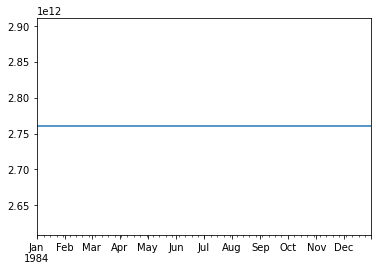

In [89]:
# Generate sample data
water_level_org = pd.read_csv('../data/DAHITI_Data/Lake_Victoria.csv')
ids = [str(i) for i in np.array(ds['ID'][:])]

## remove and create the folder
if os.path.isdir('./output/'):
    shutil.rmtree('./output/')
os.makedirs('./output/')

for j in np.arange(1984,1985):
    
    ##
    time_index = pd.date_range(start=str(j)+'-01-01', end=str(j)+'-12-31', freq='D')
    data_array1 = xr.DataArray(-9999.0, coords=[time_index, ids], dims=['time', 'n'])
    data_array2 = xr.DataArray(-9999.0, coords=[time_index, ids], dims=['time', 'n'])
    data_array3 = xr.DataArray(np.array(ds['ID'][:]), coords=[ids], dims=['n'])
    dataset = xr.Dataset({'target_vol': data_array1,'abs_inj':data_array2,'ID':data_array3}) 
    dataset['ID'] = dataset['ID'].astype(int)
    dataset['target_vol'] = dataset['target_vol'].astype(float)

    ## adding the target volume for lake vicotoria
    water_level = water_level_org.copy()
    water_level = water_level.drop(columns = 'error')
    water_level['date'] = pd.to_datetime(water_level['date'])  # Convert 'Date' column to datetime type
    water_level = water_level.set_index('date')  # Set 'Date' column as the index
    water_level = water_level.resample('D').asfreq()
    water_level['water_level'] = water_level['water_level'].interpolate(method='linear')
    water_level = water_level.reindex(time_index)
    water_level['water_level'] = water_level['water_level'].fillna(1135)
    water_level['storage'] = (water_level['water_level']-1135)*6.716622*10**10+2.76*10**12
    water_level['storage'].plot()

    ## pass the water level for lake victoria to the dataset
    ID = dataset['ID'][:]
    idx = np.where(ID== 7000016)[0].item() # lake victoria ID in 
    dataset['target_vol'][:,idx][:] = np.array(water_level['storage'])
    #dataset['ID'] = dataset['ID'].astype(float)
    
    ## save the xarray dataset as netcdf file
    if os.path.isfile('./output/WM_'+str(j)+'.nc'):
        os.remove('./output/WM_'+str(j)+'.nc')
    dataset.to_netcdf('./output/WM_'+str(j)+'.nc',\
                      encoding = {var: {'_FillValue': -9999, 'zlib': True, 'complevel': 9} for var in dataset.data_vars})
    
    

In [90]:
dataset

<xarray.Dataset>
Dimensions:     (time: 366, n: 298277)
Coordinates:
  * time        (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * n           (n) <U7 '1000000' '1000001' '1000002' ... '8427034' '8427689'
Data variables:
    target_vol  (time, n) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    abs_inj     (time, n) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    ID          (n) int64 1000000 1000001 1000002 ... 8426992 8427034 8427689

In [75]:
dataset.variables

Frozen({'time': <xarray.IndexVariable 'time' (time: 366)>
array(['1988-01-01T00:00:00.000000000', '1988-01-02T00:00:00.000000000',
       '1988-01-03T00:00:00.000000000', ..., '1988-12-29T00:00:00.000000000',
       '1988-12-30T00:00:00.000000000', '1988-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]'), 'ID': <xarray.IndexVariable 'ID' (ID: 298277)>
array([1000000, 1000001, 1000002, ..., 8426992, 8427034, 8427689]), 'target_vol': <xarray.Variable (time: 366, ID: 298277)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]), 'abs_inj': <xarray.Variable (time: 366, ID: 298277)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999.